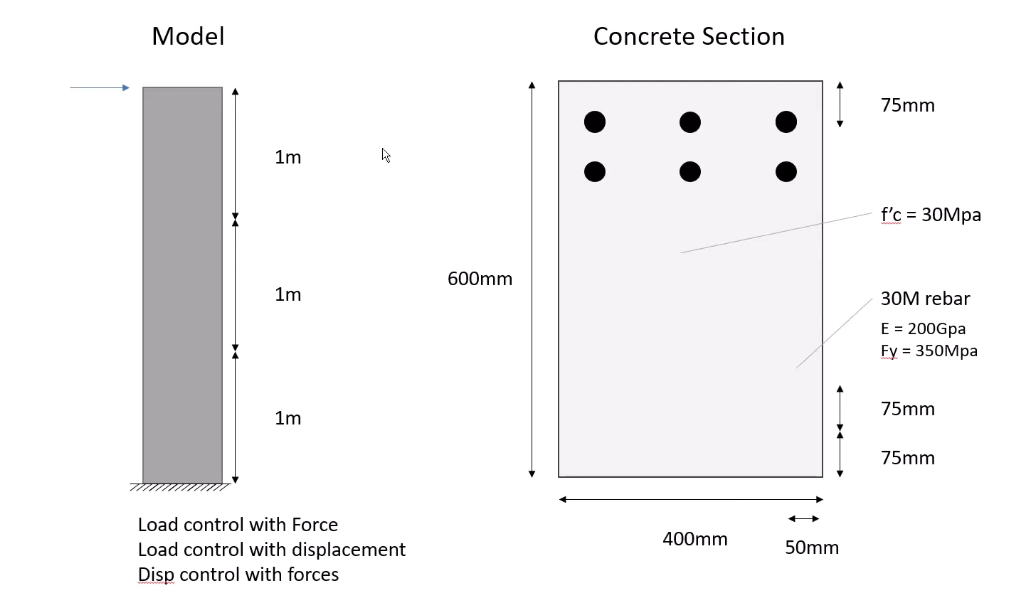

### Importing Packages

In [24]:
from openseespy import opensees as ops
import opsvis as ovs
import numpy as np
import matplotlib.pyplot as plt 



### Units conversion

In [25]:
m = 1.0
mm = 0.001 * m

Pa = 1.0
kPa = 1000 * Pa
MPa = 1000 * kPa
GPa = 1000 * MPa

N = 1.0
kN = 1000*N

### Global Variables

In [26]:
linTrans = 1
pdeltaTrans = 2

### Section Definition

In [27]:
def getSections(drawSection = False):
    ops.wipe()
    ops.model('Basic', '-ndm', 2, '-ndf', 3)
    
    ##mat #tag           #elasticity #material tag
    #Esteel, test_steel = 200*GPa, 1
    #Eflexible, flexible = 1*kPa , 10
    #Erigid, rigid = 100*kPa*GPa, 11
    #
    ##test materials
    #ops.uniaxialMaterial('Elastic', test_steel, Esteel)
    #ops.uniaxialMaterial('Elastic', flexible, Eflexible)
    #ops.uniaxialMaterial('Elastic', rigid, Erigid)

    #steel materials for using in actual (rebars)
    steel_02 = 2
    fy = 350. * MPa
    E0 = 200. * GPa
    b = 0.0005
    #uniaxialMaterial('Steel02', matTag, Fy, E0, b)
    ops.uniaxialMaterial('Steel02', steel_02, fy, E0, b)

    #concrete materials: for concrete section
    concrete = 3
    fpc = 30*MPa
    fpcu = fpc*0.1
    epsc0 = -0.002
    epsU = epsc0*8
    lam = 0.2
    ft = -fpc/30
    Ets = 2*fpc / (epsc0 * 20)
    
    #uniaxialMaterial('Concrete02', matTag, fpc, epsc0, fpcu, epsU, lambda, ft, Ets)
    ops.uniaxialMaterial('Concrete02', concrete, fpc, epsc0, fpcu, epsU, lam, ft, Ets)


    #geometry preprocessing for fibres:
    #coordinates of rebar (wrt centroid of section)
    z_coors = np.array([-150, 0, 150])*mm
    #y_coors = np.array([-225, -150, 150, 225])*mm
    y_coors = np.array([150, 225])*mm
    A_rebar = np.pi*(30*mm)**2/4

    #coordinates of vertices of concrete section
    d_conc = 600*mm #section depth
    b_conc = 400*mm #section width
    coor_conc = [-d_conc/2, b_conc/2, -d_conc/2, -b_conc/2, d_conc/2, -b_conc/2, d_conc/2, b_conc/2]
    #no of fiber divisions in concrete
    ndivz = 1
    ndivy = 50
    
    ##test fiber section
    ##section('Fiber', secTag, '-GJ', GJ)
    #test_section = 1
    #ops.section('Fiber', test_section)
    ##concrete fiber patch
    ##patch('quad', matTag, numSubdivIJ, numSubdivJK, *crdsI, *crdsJ, *crdsK, *crdsL)
    #ops.patch('quad', test_steel, ndivz, ndivy, *coor_conc)
    ##rebars fiber
    #for i,z in enumerate(z_coors):
    #    for j,y in enumerate(y_coors):
    #        #fiber(yloc, zloc, A, matTag)
    #        ops.fiber(y,z, A_rebar, test_steel)

    #main section
    #section('Fiber', secTag, '-GJ', GJ)
    actual_section = 2
    ops.section('Fiber', actual_section)
    #concrete fiber patch
    #patch('quad', matTag, numSubdivIJ, numSubdivJK, *crdsI, *crdsJ, *crdsK, *crdsL)
    ops.patch('quad', concrete, ndivz, ndivy, *coor_conc)
    #rebars fiber
    for i,z in enumerate(z_coors):
        for j,y in enumerate(y_coors):
            #fiber(yloc, zloc, A, matTag)
            ops.fiber(y,z, A_rebar, steel_02)


    #geometric transformation
    ops.geomTransf("Linear", linTrans)
    ops.geomTransf("PDelta", pdeltaTrans)

    #integration specifications
    #beamIntegration('Lobatto', tag, secTag, NumIntPts)
    #ops.beamIntegration('Lobatto', 1, test_section, 4)
    ops.beamIntegration('Lobatto', 2, actual_section, 4)

    #opsv.fib_sec_list_to_cmds(fib_sec_1)
    #matcolor = ['r', 'lightgrey', 'gold', 'w', 'w', 'w']
    #opsv.plot_fiber_section(fib_sec_1, matcolor=matcolor)
    #plt.axis('equal')
    ## plt.savefig('fibsec_rc.png')
    #plt.show()
    yz_rebar = np.zeros([len(y_coors)*len(z_coors), 2])
    for i,y in enumerate(y_coors):
        for j,z in enumerate(z_coors):
            yz_rebar[i * len(z_coors) + j, :] = [y,z]
    fib_sec_list = [['section', 'Fiber', actual_section, ],
                    ['patch', 'quad', concrete, ndivz, ndivy, *coor_conc],
                    #*[['fiber', y,z, A_rebar, steel_02] for [y,z] in yz_rebar], #but fiber plotting is not supported 
                    #so, we will plot circular patch for the steel rebars
                    *[['patch','circ',steel_02, 1 , 1, *[y,z], *[np.sqrt(4*A_rebar/np.pi)/2, np.sqrt(4*A_rebar/np.pi)/2], *[0,360]] for [y,z] in yz_rebar]
                    #last in the list, stacked at top
                   ]
    if drawSection:
        matcolor = ['r', 'lightgrey', 'gold', 'r', 'r', 'r']
        ovs.plot_fiber_section(fib_sec_list, matcolor=matcolor)
        plt.axis('equal')
        plt.title('Fiber Section of the RCC Colum')
        plt.show()
    return fib_sec_list

In [28]:
def getModel():
    #nodes definition
    nodes_x = np.zeros(4, dtype=float)
    nodes_y = np.arange(0, 4, 1, dtype=float)

    for i in range(len(nodes_x)):
        ops.node(i+1, nodes_x[i], nodes_y[i])

    #fixing nodes
    ops.fix(1, 1, 1, 1)

    #define elements
    #element('forceBeamColumn', eleTag, *eleNodes, transfTag, integrationTag, '-iter', maxIter=10, tol=1e-12)
    integration_test_tag = 1
    integration_actual_tag = 2
    ops.element('forceBeamColumn', 1, *[1,2], linTrans, integration_actual_tag, '-iter', 30, 1e-12)
    ops.element('forceBeamColumn', 2, *[2,3], linTrans, integration_actual_tag, '-iter', 30, 1e-12)
    ops.element('forceBeamColumn', 3, *[3,4], linTrans, integration_actual_tag, '-iter', 30, 1e-12)

### Checking for Fiber Sections and Cantilever Model

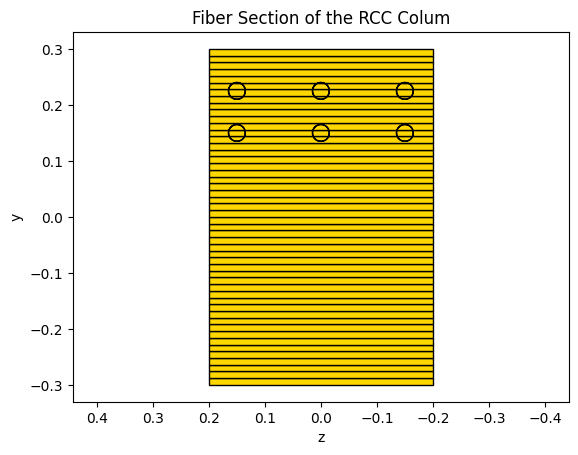

In [29]:
fiber_section_list = getSections(drawSection=True)
getModel()

<Axes: >

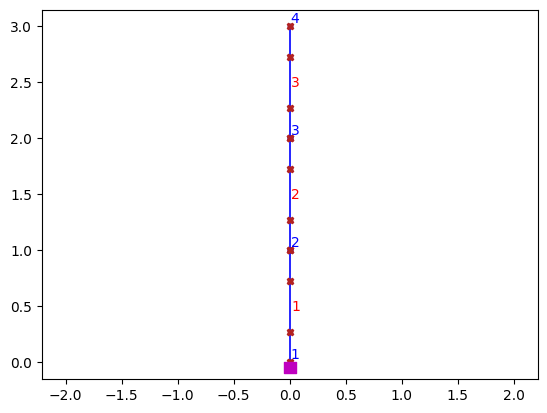

In [30]:
ovs.plot_model()

## Analysis

#### Analysis Variables


In [31]:
P0_x = 1.0*kN
DEL_x = 0.00001*m
#time series tags
const_TS = 1 
lin_TS = 2



#### Preprocessing

#### Load Control with Force

In [32]:
def loadControlForce_Pushover(NumSteps):
    controlNode = 4
    controlNodeDof = 1
    #time series
    ops.timeSeries('Constant', const_TS)
    ops.timeSeries('Linear', lin_TS)

    #load pattern
    ops.pattern('Plain',1, lin_TS)
    ops.load(controlNode, *[P0_x, 0.0, 0.0])

    #analysis commands
    ops.constraints("Transformation")
    ops.numberer("Plain")
    ops.system("BandGeneral")
    ops.algorithm("Newton")
    #integrator('LoadControl', incr, numIter=1, minIncr=incr, maxIncr=incr)
    ops.integrator('LoadControl', 1.0)
    #ops.test('NormDispIncr', tol, iter, pFlag=0, nType=2)
    ops.test('NormDispIncr', 1.0e-11, 50)
    ops.analysis("Static")
    #recorder('Node', '-file', filename, , '-timeSeries', tsTag, '-time','-closeOnWrite', '-node', *nodeTags=[],'-dof', *dofs=[], respType)
    ops.recorder('Node', '-file', "LoadControlForce/displacements.txt",'-closeOnWrite', '-time', '-node', *[4], '-dof', *[1,2,3], 'disp')
    ops.recorder('Node', '-file', "LoadControlForce/reactions.txt", '-closeOnWrite', '-time', '-node', *[1], '-dof', *[1,2,3], 'reaction')
    
    #analyze(numIncr=1, dt=0.0, dtMin=0.0, dtMax=0.0, Jd=0)
    ops.record()
    status = ops.analyze(NumSteps)
    return status


#### Load Control with Displacement

In [33]:
def loadControlDisplacement_Pushover(NumSteps):
    controlNode = 4
    controlNodeDof = 1
    #time series
    ops.timeSeries('Constant', const_TS)
    ops.timeSeries('Linear', lin_TS)

    #load pattern
    ops.pattern('Plain',1, lin_TS)
    #now instead of using load at control node, we use sp command single point constraint
    #XXXX ops.load(controlNode, *[P0_x, 0.0, 0.0]) XXXXXX
    ops.sp(controlNode, controlNodeDof, DEL_x)

    #analysis commands
    ops.constraints("Transformation")
    ops.numberer("Plain")
    ops.system("BandGeneral")
    ops.algorithm("Newton")
    #integrator('LoadControl', incr, numIter=1, minIncr=incr, maxIncr=incr)
    ops.integrator('LoadControl', 1.0)
    #ops.test('NormDispIncr', tol, iter, pFlag=0, nType=2)
    ops.test('NormDispIncr', 1.0e-11, 50)
    ops.analysis("Static")
    
    #recorder('Node', '-file', filename, , '-timeSeries', tsTag, '-time','-closeOnWrite', '-node', *nodeTags=[],'-dof', *dofs=[], respType)
    ops.recorder('Node', '-file', "LoadControlDisplacement/displacements.txt",'-closeOnWrite', '-time', '-node', *[4], '-dof', *[1,2,3], 'disp')
    ops.recorder('Node', '-file', "LoadControlDisplacement/reactions.txt", '-closeOnWrite', '-time', '-node', *[1], '-dof', *[1,2,3], 'reaction')
    
    #analyze(numIncr=1, dt=0.0, dtMin=0.0, dtMax=0.0, Jd=0)
    ops.record()
    status = ops.analyze(NumSteps)
    return status

#### Displacement Control with Force

In [34]:
def dispControlForce_Pushover(NumSteps):
    controlNode = 4
    controlNodeDof = 1
    #time series
    ops.timeSeries('Constant', const_TS)
    ops.timeSeries('Linear', lin_TS)

    #load pattern
    ops.pattern('Plain',1, lin_TS)
    #now instead of using load at control node, we use sp command single point constraint
    ops.load(controlNode, *[P0_x, 0.0, 0.0])
    #xxx ops.sp(controlNode, controlNodeDof, DEL_x)xxxx

    #analysis commands
    ops.constraints("Transformation")
    ops.numberer("Plain")
    ops.system("BandGeneral")
    ops.algorithm("Newton")
    #integrator('DisplacementControl', nodeTag, dof, incr, numIter=1, dUmin=incr, dUmax=incr)
    ops.integrator('DisplacementControl', controlNode, controlNodeDof, DEL_x)
    #ops.test('NormDispIncr', tol, iter, pFlag=0, nType=2)
    ops.test('NormDispIncr', 1.0e-11, 50)
    ops.analysis("Static")

    #recorder('Node', '-file', filename, , '-timeSeries', tsTag, '-time','-closeOnWrite', '-node', *nodeTags=[],'-dof', *dofs=[], respType)
    ops.recorder('Node', '-file', "DisplacementControlForce/displacements.txt",'-closeOnWrite', '-time', '-node', *[4], '-dof', *[1,2,3], 'disp')
    ops.recorder('Node', '-file', "DisplacementControlForce/reactions.txt", '-closeOnWrite', '-time', '-node', *[1], '-dof', *[1,2,3], 'reaction')
    
    #analyze(numIncr=1, dt=0.0, dtMin=0.0, dtMax=0.0, Jd=0)
    ops.record()
    status = ops.analyze(NumSteps)
    return status    

### Plot Functions

In [35]:
LCF = 'LoadControlForce'
LCD = 'LoadControlDisplacement'
DCF = 'DisplacementControlForce'

def plotPushover(AnalysisType):
    disp_filename = AnalysisType + '/displacements.txt'
    reaction_filename = AnalysisType + '/reactions.txt'

    displacements = np.loadtxt(disp_filename, delimiter=" ")
    reactions = np.loadtxt(reaction_filename, delimiter=" ")

    disp_x = displacements[:, 1]
    base_shear = -reactions[:, 1]

    fig, ax = plt.subplots()
    ax.plot(disp_x, base_shear)
    return displacements, reactions

### Example Analysis

after: 50 iterations  current Norm: 936.977 (max: 1e-11, Norm deltaR: 680257)
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 1 with domain at load factor 2
OpenSees > analyze failed, returned: -3 error flag


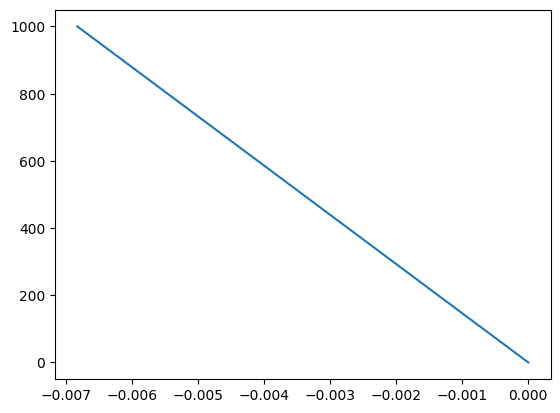

In [36]:
#loadControlForce
getSections()
getModel()
loadControlForce_Pushover(NumSteps=300)
Disp, Rxn = plotPushover(LCF)

after: 50 iterations  current Norm: 3.38177e-06 (max: 1e-11, Norm deltaR: 1605.88)
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 6 with domain at load factor 12.9261
OpenSees > analyze failed, returned: -3 error flag


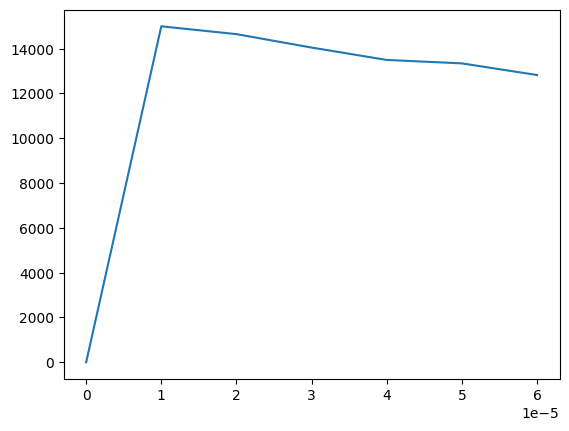

In [37]:
#loadControlForce
getSections()
getModel()
dispControlForce_Pushover(NumSteps=300)
Disp, Rxn = plotPushover(DCF)

after: 50 iterations  current Norm: 2.80239e-05 (max: 1e-11, Norm deltaR: 700.717)
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 4 with domain at load factor 5
OpenSees > analyze failed, returned: -3 error flag


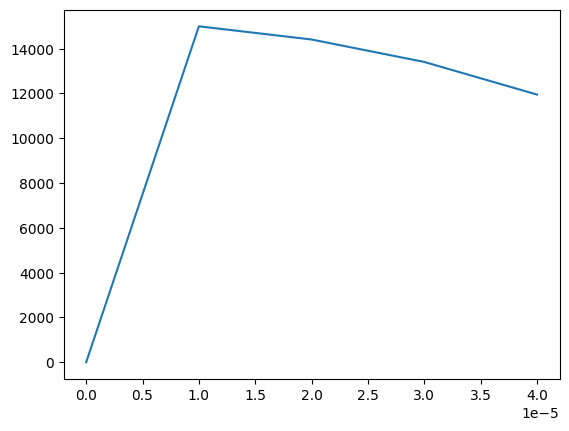

In [38]:
#loadControlForce
getSections()
getModel()
loadControlDisplacement_Pushover(NumSteps=300)
Disp, Rxn = plotPushover(LCD)